In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
# from pandas._libs.tslibs import Second
from tqdm import tqdm
import os
import intervals as I

import dpkt
import sys

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

# python classify.py 100321090205.csv  10032100.pcap

TYPENO = 3 # NO
TYPEBOTH = 2 # BOTH
TYPELTE = 1 # LTE
TYPENR = 0 # NR


LTETYPENO = 3 # NO
LTETYPEBOTH = 2 # BOTH
LTETYPELTE = 1 # LTE
LTETYPENR = 0 # NR

NRTYPENO = 4 # NO
NRTYPEBOTH = 5 # BOTH
NRTYPELTE = 6 # LTE
NRTYPENR = 7 # NR


LTE = 0
NR = 1


# 5 0 0 0 0 1 1 0 0 3 0 0 0 0 0 1 0 44 1 0 4142.161921 0.410393 15.427686 134.0 524.0

def to_zero(x):
    return x if x != '-' else 0

class Signal_analysis():
    def __init__(self, filename, mifile):
        pass

    def get_time_diff(self):
        l = []
        diffl = []
        for i in range(len(self.mifile)):
            if self.mifile.loc[i, r"lte-rrc.t304"] or self.mifile.loc[i, r"nr-rrc.t304"]:
                l.append(self.mifile.loc[i, "time"])    
        for i in range(1, len(l)):
            diffl.append(l[i]- l[i-1])

        for i in range(len(diffl)):
            if diffl[i] < dt.timedelta(seconds = 2):
                print(diffl[i])


    def get_ret_server(self, pcapcsv):
        df = pd.read_csv(pcapcsv, sep='@')
        time_list = []
        for i in range(len(df)):
            if "Retran" in df.loc[i, "_ws.col.Info"]:
                time_list.append(df.loc[i, "frame.time"][:-4])
        time_list = pd.to_datetime(time_list)
        return time_list

    def get_ret_ue(self, pcapcsv):
        df = pd.read_csv(pcapcsv, sep='@')
        time_list = []
        for i in range(len(df)):
            if "ip.dst" == "140.112.20.183" and "Retran" in df.loc[i, "_ws.col.Info"]:
                time_list.append(df.loc[i, "frame.time"][:-4])
        time_list = pd.to_datetime(time_list)
        return time_list
    
    
    def get_dupack(self, pcapcsv):
        df = pd.read_csv(pcapcsv, sep='@')
        time_list = []
        for i in range(len(df)):
            if "Dup ACK" in df.loc[i, "_ws.col.Info"]:
                time_list.append(df.loc[i, "frame.time"][:-4])
        time_list = pd.to_datetime(time_list)
        return time_list
    


In [2]:
cellinfo = r"C:\Users\USER\Desktop\data\0406/040622061828_new.csv"
mifile = r"C:\Users\USER\Desktop\data\0406/diag_log_20220406_184759_b1d46285fe5943f4381a649c8f15d3bd_Xiaomi-M2007J3SY_46697.mi2log_ver2.txt_3.csv"
dlfile = r"C:\Users\USER\Desktop\data\0406/DL_0406.csv"
ulfile = r"C:\Users\USER\Desktop\data\0406/UE_0406.csv"


In [10]:
ret_list = X.get_ret_server(dlfile)

In [11]:
ret_list_ue = X.get_ret_server(ulfile)

In [12]:
def mi_event_parsing(miinfofile, nr_time_intervals):

    nr_pci = None
    
    lte_4G_handover_list = []   #4G 狀態下LTE eNB 的 handover
    
    nr_setup_list = []          #gNB cell addition
    nr_handover_list = []       #gNB cell changes (eNB stays the same)
    nr_removal_list = []        #gNB cell removal
        
    lte_5G_handover_list = []   #(eNB1, gNB1) -> (eNB2, gNB1) #gNB stays the same
    nr_lte_handover_list = []   #both NR cell and LTE cell have handover
    
    scg_failure_list = []       #gNB handover failure
    reestablish_list = []       #eNB handover failure
    
    nr_handover = 0
    nr_handover_start_index = None
    lte_handover = 0
    lte_handover_start_index = None
    nr_release = 0
    nr_release_start_index = None
    
    handover_num = 0
    
    #initialization
    #----------------------------------------------------------------
    if miinfofile.loc[0, "time"] in nr_time_intervals:
        nr_pci = 1000000            #先設置一個數 dummy nr pci
    
    for i in range(len(miinfofile)):       
        if miinfofile.loc[i, "nr-rrc.t304"]:
            if nr_handover == 0:    
                nr_handover = 1
                nr_handover_start_index = i
                
        if miinfofile.loc[i, "lte-rrc.t304"]:
            if lte_handover == 0:
                lte_handover = 1
                lte_handover_start_index = i
                
        if miinfofile.loc[i, "nr-Config-r15: release (0)"]:
            if nr_release == 0:
                nr_release = 1
                nr_release_start_index = i
           
        if (nr_handover or lte_handover or nr_release) and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            handover_num +=1
        
        
        #handover 種類分類
        #------------------------------------------------------------------------------
        if lte_handover and not nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just lte cell handover event
            lte_handover = 0
            lte_4G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
        if nr_handover and not lte_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:  # just nr cell handover event
            nr_handover = 0
            if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]:     #This if-else statement classifies whether it is nr addition or nr handover
                nr_setup_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])       
            else:
                nr_handover_list.append([miinfofile.loc[nr_handover_start_index, "time"], miinfofile.loc[i, "time"]])
                
            #additional judgement:
            #----------------------------
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"] and nr_pci != None:
            #    print("Warning: dualConnectivityPHR setup may not mean nr cell addition", mi_file, i)
            #if miinfofile.loc[nr_handover_start_index, "dualConnectivityPHR: setup (1)"]==0 and not (nr_pci != None and nr_pci != miinfofile.loc[nr_handover_start_index, "nr_pci"]): 
            #    print("Warning: nr-rrc.t304 without dualConnectivityPHR setup may not mean nr cell handover", mi_file, i, nr_handover_start_index, miinfofile.loc[nr_handover_start_index, "nr_pci"], nr_pci)
                
            #nr_pci update lte_handover_start_time
            nr_pci = miinfofile.loc[nr_handover_start_index, "nr_pci"]
            
            
        if lte_handover and nr_handover and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:      # both nr cell and lte cell handover event
            lte_handover = 0
            nr_handover = 0
            if nr_pci == miinfofile.loc[lte_handover_start_index, "nr_pci"]:
                lte_5G_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            else:
                nr_lte_handover_list.append([miinfofile.loc[lte_handover_start_index, "time"], miinfofile.loc[i, "time"]])
            
            #nr_pci update
            nr_pci = miinfofile.loc[lte_handover_start_index, "nr_pci"]
            
        if nr_release and miinfofile.loc[i, "rrcConnectionReconfigurationComplete"]:
            nr_pci = None
            nr_release=0
            nr_removal_list.append([miinfofile.loc[nr_release_start_index, "time"], miinfofile.loc[i, "time"]])
        if miinfofile.loc[i, "scgFailureInformationNR-r15"]:
            scg_failure_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])
        if miinfofile.loc[i, "rrcConnectionReestablishmentRequest"]:
            reestablish_list.append([miinfofile.loc[i, "time"], miinfofile.loc[i, "time"]])
            
    return [lte_4G_handover_list, nr_setup_list, nr_handover_list, nr_removal_list, lte_5G_handover_list, nr_lte_handover_list, scg_failure_list, reestablish_list], handover_num

#This function firstly generates three intervals for each [handover_start, handover_end] in handover_list
#   a. before the handover_start event: [handover_start-second, handover_start]
#   b. during the handover events: [handover_start, handover_end]
#   c. after the handover_end event: [handover_end, handover_end+second]
#Then, it returns the overall intervals before/during/after the handover event
#--------------------------------------------------------------------
def get_before_during_after_intervals(handover_list, second):
    before_handover_intervals = I.empty()
    handover_intervals = I.empty()
    after_handover_intervals = I.empty()
    for i in range(len(handover_list)):  
        interval = I.closed( handover_list[i][0]-dt.timedelta(seconds=second), handover_list[i][0] )
        before_handover_intervals = before_handover_intervals | interval
        
        interval = I.closed( handover_list[i][0], handover_list[i][1] )
        handover_intervals = handover_intervals | interval
        
        interval = I.closed( handover_list[i][1], handover_list[i][1]+dt.timedelta(seconds=second) )
        after_handover_intervals = after_handover_intervals | interval    
    return before_handover_intervals, handover_intervals, after_handover_intervals
   
#This function returns the overall length of the intervals
#--------------------------------------------------------------------
def get_sum_intervals(intervals):
    if intervals.is_empty():
        return 0
    sum = 0
    for x in intervals:
        sum += (x.upper - x.lower)/dt.timedelta(seconds=1)
    return sum


In [13]:
event_names = [
    "lte_4G_handover",
    "nr_setup",
    "nr_handover",
    "nr_removal",
    "lte_5G_handover",
    "nr_lte_handover_list",
    "scg_failure",
    "reestablish"
]

column_names = []

for i in range(len(event_names)-2):
    column_names += ["before_"+event_names[i]+"_intervals", "during_"+event_names[i]+"_intervals", "after_"+event_names[i]+"_intervals"]
for i in range(len(event_names)-2, len(event_names)):
    column_names += ["before_"+event_names[i]+"_intervals", "after_"+event_names[i]+"_intervals"]
    
column_names += ["nr_time_intervals", "weak_nr_intervals", "weak_lte_intervals"]
print("column_names=", column_names)

sum_intervals = [0] * len(column_names)
sum_packet_loss = [0] * len(column_names)
sum_stable_intervals = 0

column_names= ['before_lte_4G_handover_intervals', 'during_lte_4G_handover_intervals', 'after_lte_4G_handover_intervals', 'before_nr_setup_intervals', 'during_nr_setup_intervals', 'after_nr_setup_intervals', 'before_nr_handover_intervals', 'during_nr_handover_intervals', 'after_nr_handover_intervals', 'before_nr_removal_intervals', 'during_nr_removal_intervals', 'after_nr_removal_intervals', 'before_lte_5G_handover_intervals', 'during_lte_5G_handover_intervals', 'after_lte_5G_handover_intervals', 'before_nr_lte_handover_list_intervals', 'during_nr_lte_handover_list_intervals', 'after_nr_lte_handover_list_intervals', 'before_scg_failure_intervals', 'after_scg_failure_intervals', 'before_reestablish_intervals', 'after_reestablish_intervals', 'nr_time_intervals', 'weak_nr_intervals', 'weak_lte_intervals']


In [14]:
# f = open(pcap_file, "rb")
# pcap = dpkt.pcap.Reader(f)


cellinfo = r"C:\Users\USER\Desktop\data\0406/040622061828_new.csv"
mifile = r"C:\Users\USER\Desktop\data\0406/diag_log_20220406_184759_b1d46285fe5943f4381a649c8f15d3bd_Xiaomi-M2007J3SY_46697.mi2log_ver2.txt_3.csv"
dlfile = r"C:\Users\USER\Desktop\data\0406/DL_0406.csv"
ulfile = r"C:\Users\USER\Desktop\data\0406/UE_0406.csv"


cellinfofile = pd.read_csv(cellinfo)
cellinfofile.loc[:, "Date"] = pd.to_datetime(cellinfofile.loc[:, "Date"])

miinfofile = pd.read_csv(mifile)
miinfofile.loc[:, "time"] = pd.to_datetime(miinfofile.loc[:, "time"]) + dt.timedelta(hours=8)

#======================lost time (and latency)=============================
# loss_time, latency = get_loss_latency(pcap)

#======================before mi event parse, parse NR intervals first=====
nr_time_intervals = I.empty()
if cellinfofile.loc[0, "NR_SSRSRP"] != "-":
    nr_time_intervals = I.singleton(cellinfofile.loc[0, "Date"])
for i in range(1, len(cellinfofile)):
    if cellinfofile.loc[i, "NR_SSRSRP"] != "-":
        nr_time_intervals = nr_time_intervals | I.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])
weak_nr_intervals = I.empty()
if cellinfofile.loc[0, "NR_SSRSRP"] != "-" and int(cellinfofile.loc[0, "NR_SSRSRP"]) <= -90:
    weak_nr_intervals = I.singleton(cellinfofile.loc[0, "Date"])
for i in range(1, len(cellinfofile)):
    if cellinfofile.loc[i, "NR_SSRSRP"] != "-" and int(cellinfofile.loc[i, "NR_SSRSRP"]) <= -90:
        weak_nr_intervals = weak_nr_intervals | I.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])
weak_lte_intervals = I.empty()
if cellinfofile.loc[0, "LTE_RSRP"] != "-" and int(cellinfofile.loc[0, "LTE_RSRP"]) <= -90:
    weak_lte_intervals = I.singleton(cellinfofile.loc[0, "Date"])
for i in tqdm(range(1, len(cellinfofile))):
    if cellinfofile.loc[i, "LTE_RSRP"] != "-" and int(cellinfofile.loc[i, "LTE_RSRP"]) <= -90:
        weak_lte_intervals = weak_lte_intervals | I.openclosed(cellinfofile.loc[i-1, "Date"] , cellinfofile.loc[i, "Date"])

#======================mi event parse======================================  
handover_event_lists, handover_num = mi_event_parsing(miinfofile, nr_time_intervals)

#======================making intervals====================================
intervals = []

for handover_event_list in handover_event_lists[:-2]:
    before_intervals, during_intervals, after_intervals = get_before_during_after_intervals(handover_event_list, 1)     #抓取前後一秒
    intervals += [before_intervals, during_intervals, after_intervals].copy()
for handover_event_list in handover_event_lists[-2:]:
    before_intervals, _, after_intervals = get_before_during_after_intervals(handover_event_list, 3)                    #抓取前後三秒
    intervals += [before_intervals, after_intervals].copy()    

intervals += [nr_time_intervals, weak_nr_intervals, weak_lte_intervals]
#================================judgement=================================
out = pd.DataFrame(columns = column_names, dtype=object)

#------check time-------
start_time = miinfofile.loc[0, "time"]
if cellinfofile.loc[0, "Date"] > start_time:
    start_time = cellinfofile.loc[0, "Date"]
# if latency[0][0] > start_time:
#     start_time = latency[0][0]
end_time = miinfofile.loc[len(miinfofile)-1, "time"]
if cellinfofile.loc[len(cellinfofile)-1, "Date"] < end_time:
    end_time = cellinfofile.loc[len(cellinfofile)-1, "Date"]
# if latency[0][-1] < end_time:
#     end_time = latency[0][-1]

100%|███████████████████████████████████████████████████████████████████████████| 1193/1193 [00:00<00:00, 32235.82it/s]


In [16]:
for loss_index in range(len(ret_list)):    
    if ret_list[loss_index] < start_time:
        continue
    if ret_list[loss_index] > end_time:
        continue

    types = [0]*len(intervals)
    for i in range(len(intervals)):
        if ret_list[loss_index] in intervals[i]:
            types[i] = 1
    out.loc[loss_index] = types                

#output: number of packet loss, number of packet loss under each type, handover num, overall experiment time, file names 
output = [len(out)] + [len(out.loc[ out[column_names[i]]==1 ]) for i in range(len(column_names)-3)] + [handover_num, (end_time-start_time)/dt.timedelta(seconds=1)]
print(output)


[153, 0, 0, 10, 2, 0, 9, 2, 0, 3, 1, 0, 5, 2, 0, 1, 0, 0, 1, 1, 104, 0, 0, 92, 1758.0]


In [17]:
out

,before_lte_4G_handover_intervals,during_lte_4G_handover_intervals,after_lte_4G_handover_intervals,before_nr_setup_intervals,during_nr_setup_intervals,after_nr_setup_intervals,before_nr_handover_intervals,during_nr_handover_intervals,after_nr_handover_intervals,before_nr_removal_intervals,...,before_nr_lte_handover_list_intervals,during_nr_lte_handover_list_intervals,after_nr_lte_handover_list_intervals,before_scg_failure_intervals,after_scg_failure_intervals,before_reestablish_intervals,after_reestablish_intervals,nr_time_intervals,weak_nr_intervals,weak_lte_intervals
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
149,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
150,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
151,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1


In [19]:
for i in range(len(column_names)):
    intervals[i] = intervals[i] & I.closed(start_time, end_time)
    sum_intervals[i] += get_sum_intervals(intervals[i])

stable_intervals = I.closed(start_time, end_time)
for i in range(len(column_names)-3):
    stable_intervals = stable_intervals - intervals[i]
sum_stable_intervals += get_sum_intervals(stable_intervals)

for i in range(len(column_names)-3):
    sum_packet_loss[i] += len(out.loc[ out[column_names[i]]==1 ])

#User can decide whether save the packet loss classification as csv file
out.to_csv("all_loss_classify_7.csv", mode='a')

print(sum_stable_intervals)
print([sum_intervals[i] for i in range(len(column_names)-3)])
print([sum_packet_loss[i]/(sum_intervals[i]) for i in range(len(column_names)-3)])

3115.5781779999998
[11.729254000000001, 0.1805, 11.735888, 52.0, 28.30773, 52.0, 65.87651199999999, 40.13074400000001, 65.069062, 12.0, 0.37465, 12.0, 32.0, 1.244408, 32.0, 6.0, 0.21831, 6.0, 12.0, 12.0, 0, 0]


In [2]:
pcapcsv = r"C:\Users\User\Desktop\data\0415_red.csv"
txdf = pd.read_csv(pcapcsv, sep='@')
txdf.loc[:, 'frame.time'] = pd.to_datetime(txdf.loc[:, 'frame.time'])


C:\Users\User\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [11]:
def get_seq(txdf):
    length_packet = 362
    tseq_time_list1 = []
    tseq_time_list2 = []
#     txdf = pd.read_csv(pcapcsv,   sep = '@')
#     txdf.loc[:, 'frame.time'] = pd.to_datetime(txdf.loc[:, 'frame.time'])
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] > length_packet and txdf.loc[i, "ip.dst"] == "140.112.20.183":
            bias = txdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time) 
                delay = (packet_time - born_time).total_seconds()
                if txdf.loc[i, "ip.src"] == "192.168.102.44":
                    tseq_time_list1.append((seq, packet_time, delay))
                else:
                    tseq_time_list2.append((seq, packet_time, delay))
    return tseq_time_list1, tseq_time_list2

In [71]:
def get_seq(txdf):
    length_packet = 362
    tseq_time_dict = {}
    ip_set = set(txdf.loc[:, "ip.src"])
    for ip in ip_set:
        if ip != "192.168.1.248":
            tseq_time_dict[ip] = []
#     txdf = pd.read_csv(pcapcsv,   sep = '@')
#     txdf.loc[:, 'frame.time'] = pd.to_datetime(txdf.loc[:, 'frame.time'])
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] > length_packet and txdf.loc[i, "ip.dst"] == "192.168.1.248":
            bias = txdf.loc[i, "tcp.payload"].find("0000018")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time)
                delay = (packet_time - born_time).total_seconds()
                if delay > 0:
                    tseq_time_dict[txdf.loc[i, "ip.src"]].append((seq, packet_time, delay))
    return tseq_time_dict

In [72]:
print(set(txdf.loc[:, "ip.src"]))

{'192.168.102.44', '192.168.42.167', '140.112.20.183', '192.168.1.88'}


In [73]:
tseq_time_dict = get_seq(txdf)

100%|█████████████████████████████████████████████████████████████████████████| 79868/79868 [00:05<00:00, 13549.82it/s]


In [85]:
tseq_time_list = []
for ip in tseq_time_dict:
    print(ip, len(tseq_time_dict[ip]))
    tseq_time_dict[ip].sort(key = lambda x:x[0])
    tseq_time_list.append([ip, np.array(tseq_time_dict[ip])])

# tseq_time_list = np.array(tseq_time_list)

192.168.102.44 38886
192.168.42.167 38867
192.168.1.88 38906


C:\Users\User\AppData\Local\Temp/ipykernel_9736/2155014124.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tseq_time_list = np.array(tseq_time_list)


In [ ]:
maxseq = 0
for i in range(len(tseq_time_list)):
    
    

In [84]:
tseq_time_list

[['192.168.102.44',
  array([[1, Timestamp('2022-04-15 21:24:32.923948'), 0.003948],
         [2, Timestamp('2022-04-15 21:24:32.923948'), 0.002948],
         [3, Timestamp('2022-04-15 21:24:32.923948'), 0.001948],
         ...,
         [195389, Timestamp('2022-04-15 21:27:48.674338'), 0.003338],
         [195390, Timestamp('2022-04-15 21:27:48.674338'), 0.002338],
         [195391, Timestamp('2022-04-15 21:27:48.674338'), 0.001338]],
        dtype=object)],
 ['192.168.42.167',
  array([[77, Timestamp('2022-04-15 21:24:33.024391'), 0.012391],
         [78, Timestamp('2022-04-15 21:24:33.024391'), 0.011391],
         [79, Timestamp('2022-04-15 21:24:33.024391'), 0.010391],
         ...,
         [195383, Timestamp('2022-04-15 21:27:48.667041'), 0.003041],
         [195393, Timestamp('2022-04-15 21:27:48.678536'), 0.003536],
         [195394, Timestamp('2022-04-15 21:27:48.678536'), 0.002536]],
        dtype=object)],
 ['192.168.1.88',
  array([[21, Timestamp('2022-04-15 21:24:32.965050

In [76]:
tseq_time_list[0][1][:, 1]

array([Timestamp('2022-04-15 21:24:32.923948'),
       Timestamp('2022-04-15 21:24:32.923948'),
       Timestamp('2022-04-15 21:24:32.923948'), ...,
       Timestamp('2022-04-15 21:27:48.674338'),
       Timestamp('2022-04-15 21:27:48.674338'),
       Timestamp('2022-04-15 21:27:48.674338')], dtype=object)

In [77]:
tseq_time_list[0][1][:, 2]

array([0.003948, 0.002948, 0.001948, ..., 0.003338, 0.002338, 0.001338],
      dtype=object)

In [78]:
for i in range(len(tseq_time_list[0][1][:, 2])):
    print(i, tseq_time_list[0][1][i, 2])

0 0.003948
1 0.002948
2 0.001948
3 0.003185
4 0.002185
5 0.001185
6 0.003507
7 0.002507
8 0.001507
9 0.003978
10 0.002978
11 0.001978
12 0.003488
13 0.002488
14 0.001488
15 0.003982
16 0.002982
17 0.001982
18 0.003373
19 0.002373
20 0.001373
21 0.003753
22 0.002753
23 0.001753
24 0.003902
25 0.002902
26 0.001902
27 0.003936
28 0.002936
29 0.001936
30 0.00365
31 0.00265
32 0.00165
33 0.003221
34 0.002221
35 0.001221
36 0.003713
37 0.002713
38 0.001713
39 0.003429
40 0.002429
41 0.001429
42 0.003533
43 0.002533
44 0.001533
45 0.003564
46 0.002564
47 0.001564
48 0.003886
49 0.002886
50 0.001886
51 0.00396
52 0.00296
53 0.00196
54 0.004137
55 0.003137
56 0.001137
57 0.004247
58 0.002247
59 0.003649
60 0.002649
61 0.006223
62 0.002223
63 0.003013
64 0.003764
65 0.002764
66 0.001764
67 0.00356
68 0.00256
69 0.00156
70 0.003547
71 0.002547
72 0.003383
73 0.002383
74 0.002902
75 0.001902
76 0.002705
77 0.001705
78 0.003525
79 0.002525
80 0.003456
81 0.002456
82 0.003518
83 0.002518
84 0.002434

1729 0.002782
1730 0.002711
1731 0.001711
1732 0.002659
1733 0.001659
1734 0.003634
1735 0.002634
1736 0.003647
1737 0.002647
1738 0.003685
1739 0.002685
1740 0.003641
1741 0.002641
1742 0.003854
1743 0.002854
1744 0.001854
1745 0.003712
1746 0.002712
1747 0.001712
1748 0.003688
1749 0.002688
1750 0.001688
1751 0.002868
1752 0.001868
1753 0.001868
1754 0.002778
1755 0.002125
1756 0.002306
1757 0.001306
1758 0.003312
1759 0.002312
1760 0.003136
1761 0.002136
1762 0.003089
1763 0.002089
1764 0.003703
1765 0.002703
1766 0.002759
1767 0.002759
1768 0.001759
1769 0.003117
1770 0.002117
1771 0.001117
1772 0.002987
1773 0.001987
1774 0.000987
1775 0.0031
1776 0.0021
1777 0.0011
1778 0.002334
1779 0.002338
1780 0.002708
1781 0.001708
1782 0.002244
1783 0.001244
1784 0.003348
1785 0.002348
1786 0.003497
1787 0.002497
1788 0.003787
1789 0.002787
1790 0.003817
1791 0.002817
1792 0.001817
1793 0.003699
1794 0.002699
1795 0.001699
1796 0.003519
1797 0.002519
1798 0.001519
1799 0.003482
1800 0.00248

3390 0.002563
3391 0.001563
3392 0.003087
3393 0.002087
3394 0.001087
3395 0.003604
3396 0.002604
3397 0.001604
3398 0.002156
3399 0.002708
3400 0.002208
3401 0.001208
3402 0.00275
3403 0.00175
3404 0.003192
3405 0.002192
3406 0.003704
3407 0.002704
3408 0.003213
3409 0.002213
3410 0.003749
3411 0.002749
3412 0.003256
3413 0.002256
3414 0.001256
3415 0.00377
3416 0.00277
3417 0.00177
3418 0.00335
3419 0.00235
3420 0.00135
3421 0.002913
3422 0.002913
3423 0.001913
3424 0.002726
3425 0.002691
3426 0.001691
3427 0.00265
3428 0.00165
3429 0.00362
3430 0.00262
3431 0.003535
3432 0.002535
3433 0.003459
3434 0.002459
3435 0.003366
3436 0.002366
3437 0.003262
3438 0.002262
3439 0.001262
3440 0.003184
3441 0.002184
3442 0.001184
3443 0.003107
3444 0.002107
3445 0.001107
3446 0.003297
3447 0.002297
3448 0.001297
3449 0.002733
3450 0.003155
3451 0.002489
3452 0.001489
3453 0.004064
3454 0.003064
3455 0.003522
3456 0.002522
3457 0.003959
3458 0.002959
3459 0.003981
3460 0.002981
3461 0.003035
3462

4970 0.002107
4971 0.002948
4972 0.002785
4973 0.001785
4974 0.002778
4975 0.001778
4976 0.003675
4977 0.002675
4978 0.00356
4979 0.00256
4980 0.003459
4981 0.002459
4982 0.003214
4983 0.002214
4984 0.001214
4985 0.003131
4986 0.002131
4987 0.001131
4988 0.003034
4989 0.002034
4990 0.001034
4991 0.003933
4992 0.002933
4993 0.001933
4994 0.002807
4995 0.002739
4996 0.002645
4997 0.001645
4998 0.002656
4999 0.001656
5000 0.00349
5001 0.00249
5002 0.003451
5003 0.002451
5004 0.003325
5005 0.002325
5006 0.003215
5007 0.002215
5008 0.003018
5009 0.002018
5010 0.001018
5011 0.003909
5012 0.002909
5013 0.001909
5014 0.003791
5015 0.002791
5016 0.001791
5017 0.00368
5018 0.00268
5019 0.00168
5020 0.002456
5021 0.002382
5022 0.001382
5023 0.002273
5024 0.001273
5025 0.003159
5026 0.002159
5027 0.00298
5028 0.00298
5029 0.003871
5030 0.002871
5031 0.003761
5032 0.002761
5033 0.003342
5034 0.002342
5035 0.001342
5036 0.003097
5037 0.002097
5038 0.001097
5039 0.003854
5040 0.002854
5041 0.001854
5

6741 0.001937
6742 0.001921
6743 0.001921
6744 0.002169
6745 0.001169
6746 0.003323
6747 0.002323
6748 0.00376
6749 0.00276
6750 0.003179
6751 0.002179
6752 0.003444
6753 0.002444
6754 0.002906
6755 0.002906
6756 0.001906
6757 0.003514
6758 0.002514
6759 0.001514
6760 0.003043
6761 0.002043
6762 0.001043
6763 0.003638
6764 0.002638
6765 0.001638
6766 0.002275
6767 0.002878
6768 0.001878
6769 0.00254
6770 0.00154
6771 0.003067
6772 0.002067
6773 0.003674
6774 0.002674
6775 0.003252
6776 0.002252
6777 0.003867
6778 0.002867
6779 0.003503
6780 0.002503
6781 0.001503
6782 0.003138
6783 0.002138
6784 0.001138
6785 0.003791
6786 0.002791
6787 0.001791
6788 0.003445
6789 0.002445
6790 0.001445
6791 0.002085
6792 0.002737
6793 0.002375
6794 0.001375
6795 0.002978
6796 0.001978
6797 0.003619
6798 0.002619
6799 0.003257
6800 0.002257
6801 0.002923
6802 0.002923
6803 0.003624
6804 0.002624
6805 0.001624
6806 0.003252
6807 0.002252
6808 0.001252
6809 0.003901
6810 0.002901
6811 0.001901
6812 0.003

8286 0.0017
8287 0.00269
8288 0.002612
8289 0.001612
8290 0.002487
8291 0.001487
8292 0.003282
8293 0.002282
8294 0.003114
8295 0.002114
8296 0.003938
8297 0.002938
8298 0.00372
8299 0.00272
8300 0.003667
8301 0.002667
8302 0.001667
8303 0.003606
8304 0.002606
8305 0.001606
8306 0.003652
8307 0.002652
8308 0.001652
8309 0.003781
8310 0.002781
8311 0.001781
8312 0.002701
8313 0.002271
8314 0.002287
8315 0.001287
8316 0.003199
8317 0.002199
8318 0.00351
8319 0.00251
8320 0.003743
8321 0.002743
8322 0.002831
8323 0.001831
8324 0.002783
8325 0.002783
8326 0.001783
8327 0.003766
8328 0.002766
8329 0.001766
8330 0.003037
8331 0.002037
8332 0.001037
8333 0.003085
8334 0.002085
8335 0.001085
8336 0.002318
8337 0.00224
8338 0.002558
8339 0.001558
8340 0.002778
8341 0.001778
8342 0.003687
8343 0.002687
8344 0.002842
8345 0.002842
8346 0.002991
8347 0.001991
8348 0.003487
8349 0.002487
8350 0.003085
8351 0.002085
8352 0.001085
8353 0.003659
8354 0.002659
8355 0.001659
8356 0.003394
8357 0.002394


9990 0.002081
9991 0.003249
9992 0.002249
9993 0.003355
9994 0.002355
9995 0.003481
9996 0.002481
9997 0.001481
9998 0.003596
9999 0.002596
10000 0.001596
10001 0.003704
10002 0.002704
10003 0.001704
10004 0.003744
10005 0.002744
10006 0.001744
10007 0.002754
10008 0.002838
10009 0.002901
10010 0.001901
10011 0.002995
10012 0.001995
10013 0.004008
10014 0.003008
10015 0.003505
10016 0.002505
10017 0.004088
10018 0.003088
10019 0.003723
10020 0.002723
10021 0.003359
10022 0.002359
10023 0.001359
10024 0.003954
10025 0.002954
10026 0.001954
10027 0.003868
10028 0.002868
10029 0.001868
10030 0.003813
10031 0.002813
10032 0.001813
10033 0.002425
10034 0.002293
10035 0.001293
10036 0.002299
10037 0.001299
10038 0.003964
10039 0.002964
10040 0.003766
10041 0.002766
10042 0.003544
10043 0.002544
10044 0.003231
10045 0.002231
10046 0.003198
10047 0.002198
10048 0.001198
10049 0.003944
10050 0.002944
10051 0.001944
10052 0.003522
10053 0.002522
10054 0.001522
10055 0.003502
10056 0.002502
10057

11740 0.002734
11741 0.003447
11742 0.002447
11743 0.001447
11744 0.003193
11745 0.002193
11746 0.001193
11747 0.002974
11748 0.001974
11749 0.001974
11750 0.003759
11751 0.002759
11752 0.001759
11753 0.002321
11754 0.002008
11755 0.003076
11756 0.001076
11757 0.002253
11758 0.001253
11759 0.003569
11760 0.002569
11761 0.003983
11762 0.002983
11763 0.003258
11764 0.002258
11765 0.003487
11766 0.002487
11767 0.001487
11768 0.003671
11769 0.002671
11770 0.001671
11771 0.003921
11772 0.002921
11773 0.001921
11774 0.003229
11775 0.002229
11776 0.001229
11777 0.002308
11778 0.002591
11779 0.002747
11780 0.001747
11781 0.002013
11782 0.002013
11783 0.003429
11784 0.002429
11785 0.003749
11786 0.002749
11787 0.003115
11788 0.002115
11789 0.003349
11790 0.002349
11791 0.003761
11792 0.002761
11793 0.001761
11794 0.00405
11795 0.00305
11796 0.00205
11797 0.00346
11798 0.00246
11799 0.00146
11800 0.003885
11801 0.002885
11802 0.001885
11803 0.002245
11804 0.002554
11805 0.001554
11806 0.002749
1

13298 0.002522
13299 0.001522
13300 0.002481
13301 0.00241
13302 0.00141
13303 0.002799
13304 0.001799
13305 0.002815
13306 0.002815
13307 0.003116
13308 0.002116
13309 0.003559
13310 0.002559
13311 0.003064
13312 0.002064
13313 0.003367
13314 0.002367
13315 0.001367
13316 0.00388
13317 0.00288
13318 0.00188
13319 0.003383
13320 0.002383
13321 0.001383
13322 0.003954
13323 0.002954
13324 0.001954
13325 0.002485
13326 0.002541
13327 0.002534
13328 0.001534
13329 0.003502
13330 0.002502
13331 0.003458
13332 0.002458
13333 0.003448
13334 0.002448
13335 0.003376
13336 0.002376
13337 0.003102
13338 0.002102
13339 0.001102
13340 0.003807
13341 0.002807
13342 0.001807
13343 0.003461
13344 0.002461
13345 0.001461
13346 0.003169
13347 0.002169
13348 0.001169
13349 0.002857
13350 0.002804
13351 0.002465
13352 0.001465
13353 0.002825
13354 0.001825
13355 0.003307
13356 0.002307
13357 0.003462
13358 0.002462
13359 0.004161
13360 0.002161
13361 0.003843
13362 0.002843
13363 0.001843
13364 0.003388


15163 0.001102
15164 0.003127
15165 0.002127
15166 0.001127
15167 0.003085
15168 0.002085
15169 0.001085
15170 0.002206
15171 0.002185
15172 0.002278
15173 0.001278
15174 0.003222
15175 0.002222
15176 0.003185
15177 0.002185
15178 0.003109
15179 0.002109
15180 0.003064
15181 0.002064
15182 0.003017
15183 0.002017
15184 0.001017
15185 0.003888
15186 0.002888
15187 0.001888
15188 0.003788
15189 0.002788
15190 0.001788
15191 0.003661
15192 0.002661
15193 0.001661
15194 0.002549
15195 0.002481
15196 0.002328
15197 0.001328
15198 0.002197
15199 0.001197
15200 0.003098
15201 0.002098
15202 0.003186
15203 0.002186
15204 0.003234
15205 0.002234
15206 0.003166
15207 0.002166
15208 0.003061
15209 0.002061
15210 0.001061
15211 0.003035
15212 0.002035
15213 0.002035
15214 0.003003
15215 0.003003
15216 0.002003
15217 0.003898
15218 0.002898
15219 0.001898
15220 0.002799
15221 0.002129
15222 0.001129
15223 0.002485
15224 0.001485
15225 0.003476
15226 0.002476
15227 0.003369
15228 0.002369
15229 0.00

16890 0.000937
16891 0.002686
16892 0.00244
16893 0.00144
16894 0.002289
16895 0.001289
16896 0.003711
16897 0.002711
16898 0.003424
16899 0.002424
16900 0.003078
16901 0.002078
16902 0.003831
16903 0.002831
16904 0.003897
16905 0.002897
16906 0.001897
16907 0.003013
16908 0.002013
16909 0.001013
16910 0.003017
16911 0.002017
16912 0.001017
16913 0.00312
16914 0.00212
16915 0.00112
16916 0.00226
16917 0.002264
16918 0.002271
16919 0.001271
16920 0.003269
16921 0.002269
16922 0.003355
16923 0.002355
16924 0.003315
16925 0.002315
16926 0.003324
16927 0.002324
16928 0.003466
16929 0.002466
16930 0.001466
16931 0.003469
16932 0.002469
16933 0.001469
16934 0.003543
16935 0.002543
16936 0.001543
16937 0.00351
16938 0.00251
16939 0.00151
16940 0.002638
16941 0.002838
16942 0.002932
16943 0.001932
16944 0.003026
16945 0.001026
16946 0.003073
16947 0.002073
16948 0.003014
16949 0.002014
16950 0.002995
16951 0.001995
16952 0.003147
16953 0.002147
16954 0.001147
16955 0.003251
16956 0.002251
1695

18489 0.001759
18490 0.002995
18491 0.001995
18492 0.003364
18493 0.002364
18494 0.003493
18495 0.002493
18496 0.003698
18497 0.002698
18498 0.003726
18499 0.002726
18500 0.003995
18501 0.002995
18502 0.001995
18503 0.003116
18504 0.002116
18505 0.001116
18506 0.00361
18507 0.00261
18508 0.00161
18509 0.003595
18510 0.002595
18511 0.001595
18512 0.002204
18513 0.002781
18514 0.00243
18515 0.00143
18516 0.002947
18517 0.001947
18518 0.003527
18519 0.002527
18520 0.003106
18521 0.002106
18522 0.003694
18523 0.002694
18524 0.003363
18525 0.002363
18526 0.001363
18527 0.002958
18528 0.001958
18529 0.001958
18530 0.003568
18531 0.002568
18532 0.001568
18533 0.003153
18534 0.002153
18535 0.001153
18536 0.002767
18537 0.002299
18538 0.002888
18539 0.001888
18540 0.002412
18541 0.001412
18542 0.00289
18543 0.00289
18544 0.003513
18545 0.002513
18546 0.003455
18547 0.002455
18548 0.003511
18549 0.002511
18550 0.001511
18551 0.003519
18552 0.002519
18553 0.001519
18554 0.003422
18555 0.002422
18

20074 0.003482
20075 0.002482
20076 0.001482
20077 0.003268
20078 0.002268
20079 0.001268
20080 0.003472
20081 0.002472
20082 0.001472
20083 0.002773
20084 0.002765
20085 0.001765
20086 0.002768
20087 0.001768
20088 0.003715
20089 0.002715
20090 0.003676
20091 0.002676
20092 0.00373
20093 0.00273
20094 0.003722
20095 0.002722
20096 0.003705
20097 0.002705
20098 0.001705
20099 0.003695
20100 0.002695
20101 0.001695
20102 0.003654
20103 0.002654
20104 0.001654
20105 0.003688
20106 0.002688
20107 0.001688
20108 0.002728
20109 0.002716
20110 0.002661
20111 0.001661
20112 0.003688
20113 0.002688
20114 0.003679
20115 0.002679
20116 0.003681
20117 0.002681
20118 0.003656
20119 0.002656
20120 0.003652
20121 0.002652
20122 0.001652
20123 0.003661
20124 0.002661
20125 0.001661
20126 0.003674
20127 0.002674
20128 0.001674
20129 0.00371
20130 0.00271
20131 0.00171
20132 0.002577
20133 0.002477
20134 0.002931
20135 0.001931
20136 0.002706
20137 0.001706
20138 0.003686
20139 0.002686
20140 0.003675


21790 0.00161
21791 0.003143
21792 0.002143
21793 0.001143
21794 0.003177
21795 0.002177
21796 0.001177
21797 0.003186
21798 0.002186
21799 0.001186
21800 0.002183
21801 0.002197
21802 0.001197
21803 0.00217
21804 0.00117
21805 0.003655
21806 0.002655
21807 0.003172
21808 0.002172
21809 0.003705
21810 0.002705
21811 0.003246
21812 0.002246
21813 0.003977
21814 0.002977
21815 0.001977
21816 0.003813
21817 0.002813
21818 0.001813
21819 0.003464
21820 0.002464
21821 0.001464
21822 0.003229
21823 0.002229
21824 0.001229
21825 0.002486
21826 0.004748
21827 0.002672
21828 0.001672
21829 0.003467
21830 0.002467
21831 0.003782
21832 0.002782
21833 0.002926
21834 0.001926
21835 0.003079
21836 0.002079
21837 0.002907
21838 0.001907
21839 0.000907
21840 0.003005
21841 0.002005
21842 0.001005
21843 0.003321
21844 0.002321
21845 0.001321
21846 0.003439
21847 0.002439
21848 0.001439
21849 0.002315
21850 0.002596
21851 0.002535
21852 0.001535
21853 0.002839
21854 0.001839
21855 0.002912
21856 0.00191

23262 0.003784
23263 0.002784
23264 0.001784
23265 0.003742
23266 0.002742
23267 0.001742
23268 0.003903
23269 0.002903
23270 0.001903
23271 0.002888
23272 0.00296
23273 0.002907
23274 0.001907
23275 0.003735
23276 0.002735
23277 0.003706
23278 0.002706
23279 0.003673
23280 0.002673
23281 0.003854
23282 0.002854
23283 0.003082
23284 0.002082
23285 0.001082
23286 0.003215
23287 0.002215
23288 0.001215
23289 0.003181
23290 0.002181
23291 0.001181
23292 0.003198
23293 0.002198
23294 0.001198
23295 0.002193
23296 0.002461
23297 0.002471
23298 0.001471
23299 0.002396
23300 0.001396
23301 0.003471
23302 0.002471
23303 0.003433
23304 0.002433
23305 0.003521
23306 0.002521
23307 0.003508
23308 0.002508
23309 0.003526
23310 0.002526
23311 0.001526
23312 0.003459
23313 0.002459
23314 0.001459
23315 0.003698
23316 0.002698
23317 0.001698
23318 0.003177
23319 0.002177
23320 0.001177
23321 0.002388
23322 0.002314
23323 0.001314
23324 0.002409
23325 0.001409
23326 0.003324
23327 0.002324
23328 0.003

25114 0.003297
25115 0.002297
25116 0.001297
25117 0.003704
25118 0.002704
25119 0.001704
25120 0.004039
25121 0.003039
25122 0.002039
25123 0.003346
25124 0.002346
25125 0.001346
25126 0.002534
25127 0.002289
25128 0.002465
25129 0.001465
25130 0.002866
25131 0.001866
25132 0.003867
25133 0.002867
25134 0.004081
25135 0.003081
25136 0.003404
25137 0.002404
25138 0.003729
25139 0.002729
25140 0.004164
25141 0.003164
25142 0.001164
25143 0.00363
25144 0.00263
25145 0.00163
25146 0.004148
25147 0.003148
25148 0.001148
25149 0.003494
25150 0.002494
25151 0.001494
25152 0.002594
25153 0.002518
25154 0.001518
25155 0.002469
25156 0.001469
25157 0.003569
25158 0.002569
25159 0.003087
25160 0.002087
25161 0.003026
25162 0.002026
25163 0.003803
25164 0.002803
25165 0.003724
25166 0.002724
25167 0.001724
25168 0.004052
25169 0.003052
25170 0.002052
25171 0.003357
25172 0.002357
25173 0.001357
25174 0.003768
25175 0.002768
25176 0.001768
25177 0.002749
25178 0.002659
25179 0.002542
25180 0.00154

26849 0.001841
26850 0.002311
26851 0.001311
26852 0.003835
26853 0.002835
26854 0.003573
26855 0.002573
26856 0.003528
26857 0.002528
26858 0.003458
26859 0.002458
26860 0.003345
26861 0.002345
26862 0.001345
26863 0.003188
26864 0.002188
26865 0.001188
26866 0.003057
26867 0.002057
26868 0.001057
26869 0.00391
26870 0.00291
26871 0.00191
26872 0.002743
26873 0.002707
26874 0.002644
26875 0.001644
26876 0.003482
26877 0.002482
26878 0.003339
26879 0.002339
26880 0.00323
26881 0.00223
26882 0.003008
26883 0.002008
26884 0.003815
26885 0.002815
26886 0.001815
26887 0.003682
26888 0.002682
26889 0.001682
26890 0.003656
26891 0.002656
26892 0.001656
26893 0.003462
26894 0.002462
26895 0.001462
26896 0.002301
26897 0.002155
26898 0.002886
26899 0.001886
26900 0.002719
26901 0.001719
26902 0.00343
26903 0.00243
26904 0.003009
26905 0.002009
26906 0.003748
26907 0.002748
26908 0.003516
26909 0.002516
26910 0.003873
26911 0.002873
26912 0.001873
26913 0.003236
26914 0.002236
26915 0.001236
26

28380 0.002162
28381 0.003474
28382 0.002474
28383 0.001474
28384 0.003798
28385 0.002798
28386 0.001798
28387 0.003188
28388 0.002188
28389 0.001188
28390 0.003648
28391 0.002648
28392 0.001648
28393 0.002963
28394 0.002307
28395 0.002633
28396 0.001633
28397 0.002758
28398 0.001758
28399 0.003445
28400 0.002445
28401 0.003353
28402 0.002353
28403 0.003343
28404 0.002343
28405 0.003779
28406 0.002779
28407 0.001779
28408 0.002941
28409 0.001941
28410 0.000941
28411 0.003133
28412 0.002133
28413 0.001133
28414 0.003016
28415 0.002016
28416 0.001016
28417 0.002193
28418 0.00255
28419 0.002741
28420 0.001741
28421 0.010744
28422 0.009744
28423 0.003507
28424 0.002507
28425 0.003657
28426 0.002657
28427 0.002773
28428 0.002773
28429 0.003001
28430 0.002001
28431 0.003284
28432 0.002284
28433 0.001284
28434 0.003131
28435 0.002131
28436 0.001131
28437 0.003043
28438 0.002043
28439 0.002043
28440 0.003221
28441 0.002221
28442 0.001221
28443 0.002126
28444 0.002211
28445 0.001211
28446 0.002

30237 0.001567
30238 0.002754
30239 0.003075
30240 0.002564
30241 0.001564
30242 0.003016
30243 0.002016
30244 0.003345
30245 0.002345
30246 0.003951
30247 0.002951
30248 0.003666
30249 0.002666
30250 0.003197
30251 0.002197
30252 0.003374
30253 0.002374
30254 0.001374
30255 0.004005
30256 0.003005
30257 0.002005
30258 0.003113
30259 0.002113
30260 0.001113
30261 0.003817
30262 0.002817
30263 0.001817
30264 0.002326
30265 0.002444
30266 0.001444
30267 0.00253
30268 0.00153
30269 0.00359
30270 0.00259
30271 0.00369
30272 0.00269
30273 0.003655
30274 0.002655
30275 0.003712
30276 0.002712
30277 0.003763
30278 0.002763
30279 0.001763
30280 0.003783
30281 0.002783
30282 0.001783
30283 0.003758
30284 0.002758
30285 0.001758
30286 0.003707
30287 0.002707
30288 0.001707
30289 0.00271
30290 0.002689
30291 0.00267
30292 0.00167
30293 0.003646
30294 0.002646
30295 0.003669
30296 0.002669
30297 0.003736
30298 0.002736
30299 0.00372
30300 0.00272
30301 0.003701
30302 0.002701
30303 0.001701
30304 

31933 0.002865
31934 0.001865
31935 0.002768
31936 0.002909
31937 0.001909
31938 0.002074
31939 0.001074
31940 0.003225
31941 0.002225
31942 0.00295
31943 0.00295
31944 0.003655
31945 0.002655
31946 0.003346
31947 0.002346
31948 0.002981
31949 0.001981
31950 0.001981
31951 0.003772
31952 0.002772
31953 0.001772
31954 0.003683
31955 0.002683
31956 0.001683
31957 0.003867
31958 0.002867
31959 0.001867
31960 0.00218
31961 0.002394
31962 0.001845
31963 0.001845
31964 0.002912
31965 0.001912
31966 0.003234
31967 0.002234
31968 0.003295
31969 0.002295
31970 0.003211
31971 0.002211
31972 0.00323
31973 0.00223
31974 0.00123
31975 0.003153
31976 0.002153
31977 0.001153
31978 0.00297
31979 0.00297
31980 0.00197
31981 0.003486
31982 0.002486
31983 0.001486
31984 0.00232
31985 0.00203
31986 0.002824
31987 0.001824
31988 0.001932
31989 0.000932
31990 0.003649
31991 0.002649
31992 0.003608
31993 0.002608
31994 0.002891
31995 0.002891
31996 0.00312
31997 0.00212
31998 0.00112
31999 0.003395
32000 0.0

33666 0.002044
33667 0.00382
33668 0.00282
33669 0.00182
33670 0.003528
33671 0.002528
33672 0.001528
33673 0.003245
33674 0.002245
33675 0.001245
33676 0.003015
33677 0.002015
33678 0.001015
33679 0.002784
33680 0.002548
33681 0.002314
33682 0.001314
33683 0.002077
33684 0.001077
33685 0.003797
33686 0.002797
33687 0.003563
33688 0.002563
33689 0.00333
33690 0.00233
33691 0.002978
33692 0.001978
33693 0.003739
33694 0.002739
33695 0.001739
33696 0.003492
33697 0.002492
33698 0.001492
33699 0.003256
33700 0.002256
33701 0.001256
33702 0.003041
33703 0.002041
33704 0.001041
33705 0.002793
33706 0.002598
33707 0.001598
33708 0.00238
33709 0.00138
33710 0.003122
33711 0.002122
33712 0.003913
33713 0.002913
33714 0.003674
33715 0.002674
33716 0.003425
33717 0.002425
33718 0.003173
33719 0.002173
33720 0.001173
33721 0.002944
33722 0.002944
33723 0.001944
33724 0.003712
33725 0.002712
33726 0.001712
33727 0.003477
33728 0.002477
33729 0.001477
33730 0.002244
33731 0.00202
33732 0.002799
337

35487 0.003005
35488 0.003597
35489 0.002597
35490 0.001597
35491 0.004137
35492 0.003137
35493 0.002137
35494 0.003882
35495 0.002882
35496 0.001882
35497 0.003423
35498 0.002423
35499 0.001423
35500 0.002764
35501 0.002144
35502 0.00273
35503 0.00173
35504 0.002357
35505 0.001357
35506 0.004013
35507 0.003013
35508 0.003559
35509 0.002559
35510 0.003776
35511 0.002776
35512 0.004038
35513 0.003038
35514 0.003514
35515 0.002514
35516 0.001514
35517 0.00394
35518 0.00294
35519 0.00194
35520 0.003002
35521 0.002002
35522 0.002002
35523 0.003257
35524 0.002257
35525 0.001257
35526 0.002527
35527 0.00194
35528 0.00194
35529 0.002766
35530 0.001766
35531 0.003803
35532 0.002803
35533 0.003718
35534 0.002718
35535 0.00368
35536 0.00268
35537 0.003704
35538 0.002704
35539 0.003681
35540 0.002681
35541 0.001681
35542 0.003633
35543 0.002633
35544 0.001633
35545 0.003265
35546 0.002265
35547 0.001265
35548 0.003196
35549 0.002196
35550 0.001196
35551 0.002078
35552 0.002949
35553 0.002827
3555

37108 0.003357
37109 0.002357
37110 0.00358
37111 0.00258
37112 0.00158
37113 0.003849
37114 0.002849
37115 0.001849
37116 0.003246
37117 0.002246
37118 0.001246
37119 0.003566
37120 0.002566
37121 0.001566
37122 0.002378
37123 0.002727
37124 0.001727
37125 0.002907
37126 0.001907
37127 0.003798
37128 0.002798
37129 0.003734
37130 0.002734
37131 0.003811
37132 0.002811
37133 0.004058
37134 0.002058
37135 0.003256
37136 0.002256
37137 0.001256
37138 0.002919
37139 0.002919
37140 0.001919
37141 0.00347
37142 0.00247
37143 0.00147
37144 0.003014
37145 0.002014
37146 0.001014
37147 0.002836
37148 0.002763
37149 0.002106
37150 0.001106
37151 0.00274
37152 0.00274
37153 0.003421
37154 0.002421
37155 0.003612
37156 0.002612
37157 0.003588
37158 0.002588
37159 0.003398
37160 0.002398
37161 0.001398
37162 0.00333
37163 0.00233
37164 0.00133
37165 0.00374
37166 0.00274
37167 0.00174
37168 0.003039
37169 0.002039
37170 0.001039
37171 0.002026
37172 0.00188
37173 0.001956
37174 0.001956
37175 0.00

In [80]:
np.mean(tseq_time_list[0][1][:, 2])

0.002611407421694184

In [81]:
np.mean(tseq_time_list[1][1][:, 2])

0.0026886313839503857

In [82]:
np.mean(tseq_time_list[2][1][:, 2])

0.0027160635891636167

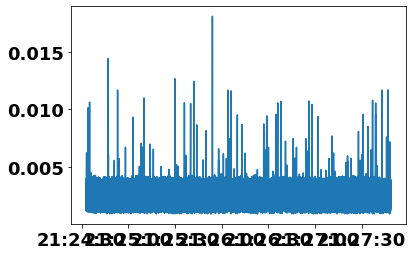

In [79]:
plt.plot(tseq_time_list[0][1][:, 1], tseq_time_list[0][1][:, 2])
plt.show()

In [21]:
"same seq diff"
l3 = []
i = 0
j = 0
while i < len(x1) and j < len(x2):
    if x1[i, 0] < x2[j, 0]:
        i +=1
    elif x1[i, 0] > x2[j, 0]:
        j +=1
    else:
        l3.append([x1[i, 0], (x1[i, 1]-x2[j, 1]).total_seconds()])
        i +=1
        j +=1
l3 = np.array(l3)

In [ ]:
index_list = len(tseq_time_list):
    while i < len(x1) and j < len(x2):
    if x1[i, 0] < x2[j, 0]:
        i +=1
    elif x1[i, 0] > x2[j, 0]:
        j +=1
    else:
        print(x1[i, 0])
        # seq, time, delay1, delay2
        l4.append([x1[i, 0], x1[i, 1], x1[i, 2], x2[j, 2]])
        i +=1
        j +=1

In [23]:
l4 = []
i = 0
j = 0
while i < len(x1) and j < len(x2):
    if x1[i, 0] < x2[j, 0]:
        i +=1
    elif x1[i, 0] > x2[j, 0]:
        j +=1
    else:
        print(x1[i, 0])
        # seq, time, delay1, delay2
        l4.append([x1[i, 0], x1[i, 1], x1[i, 2], x2[j, 2]])
        i +=1
        j +=1
l4 = np.array(l4)

21
22
23
25
26
27
29
30
31
33
34
35


In [164]:
np.mean(l3[:, 1])

0.002036406036003566

In [165]:
np.var(l3[:, 1]) ** 0.5

0.020632909920634174

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


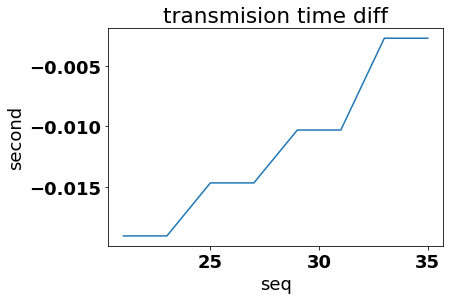

In [24]:
plt.xlabel("seq")
plt.ylabel("second")
plt.title("transmision time diff")
plt.plot(l3[:, 0], l3[:, 1])


In [25]:
print(np.mean(l4[:, 2]), np.mean(l4[:, 3]))

0.0027524999999999997 0.014449749999999997


In [26]:
print(np.var(l4[:, 2])**0.5, np.var(l4[:, 3])**0.5)

0.0008493685399558114 0.006062209733600997


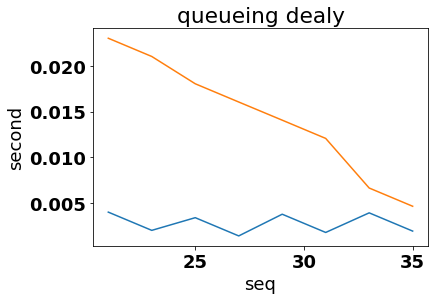

In [27]:
plt.xlabel("seq")
plt.ylabel("second")
plt.title("queueing dealy")
plt.plot(l4[:, 0], l4[:, 2])
plt.plot(l4[:, 0], l4[:, 3])
plt.show()

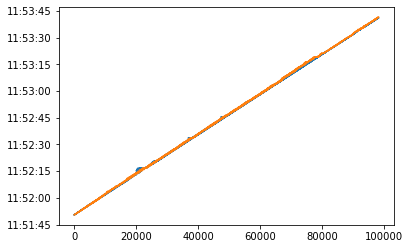

In [148]:
# plt.plot(e06[::1000]/1e9, e04[::1000])
# plt.tight_layout()
plt.plot((x1[:, 0]), x1[:, 1])
plt.plot((x2[:, 0]), x2[:, 1])
plt.show()

In [39]:
e04 = x1[:, 0].astype("int32")

In [110]:
l1, l2 = queueing_delay(txdf)

100%|███████████████████████████████████████████████████████████████████████| 216054/216054 [00:12<00:00, 16762.70it/s]


In [101]:
dt.datetime.fromtimestamp(1649599019359/1000)

datetime.datetime(2022, 4, 10, 21, 56, 59, 359000)

In [147]:
pcapcsv2 = r"C:\Users\User\Desktop\data\UE_0411_2.csv"
txdf2 = pd.read_csv(pcapcsv2, sep='@')
txdf2.loc[:, 'frame.time'] = pd.to_datetime(txdf2.loc[:, 'frame.time'])


C:\Users\User\anaconda3\envs\moxa\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [149]:
def get_seq_single(txdf):
    length_packet = 362
    tseq_time_list1 = []
#     txdf = pd.read_csv(pcapcsv,   sep = '@')
#     txdf.loc[:, 'frame.time'] = pd.to_datetime(txdf.loc[:, 'frame.time'])
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] > length_packet and txdf.loc[i, "ip.dst"] == "140.112.20.183":
            bias = txdf.loc[i, "tcp.payload"].find("000001801")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time) 
                delay = (packet_time - born_time).total_seconds()
                tseq_time_list1.append((seq, packet_time, delay))
    return tseq_time_list1

In [150]:
s1 = get_seq_single(txdf2)

100%|█████████████████████████████████████████████████████████████████████████| 46160/46160 [00:02<00:00, 15877.76it/s]


In [153]:
s1 = np.array(s1)
s1[:10]

array([[1, Timestamp('2022-04-11 11:56:46.287522'), 0.003522],
       [2, Timestamp('2022-04-11 11:56:46.287522'), 0.002522],
       [3, Timestamp('2022-04-11 11:56:46.287522'), 0.001522],
       [5, Timestamp('2022-04-11 11:56:46.292032'), 0.004032],
       [6, Timestamp('2022-04-11 11:56:46.292032'), 0.003032],
       [7, Timestamp('2022-04-11 11:56:46.292032'), 0.002032],
       [9, Timestamp('2022-04-11 11:56:46.296580'), 0.00358],
       [10, Timestamp('2022-04-11 11:56:46.296580'), 0.00258],
       [13, Timestamp('2022-04-11 11:56:46.301063'), 0.004063],
       [14, Timestamp('2022-04-11 11:56:46.301063'), 0.003063]],
      dtype=object)

In [159]:
print(np.mean(s1[:, 2]), np.var(s1[:, 2])**0.5)

0.0029928513936382855 0.001090885540497618


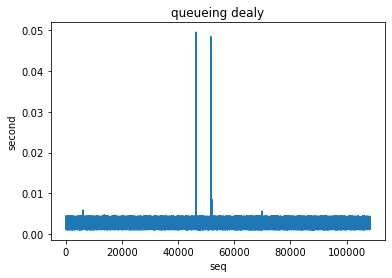

In [155]:
plt.xlabel("seq")
plt.ylabel("second")
plt.title("queueing dealy")
plt.plot(s1[:, 0], s1[:, 2])
plt.show()

In [157]:
pcapcsv3 = r"C:\Users\User\Desktop\data\UE_0411_3.csv"
txdf3 = pd.read_csv(pcapcsv3, sep='@')
txdf3.loc[:, 'frame.time'] = pd.to_datetime(txdf3.loc[:, 'frame.time'])


C:\Users\User\anaconda3\envs\moxa\lib\site-packages\dateutil\parser\_parser.py:1212: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [ ]:
def get_seq(txdf):
    length_packet = 362
    tseq_time_list1 = []
    tseq_time_list2 = []
#     txdf = pd.read_csv(pcapcsv,   sep = '@')
#     txdf.loc[:, 'frame.time'] = pd.to_datetime(txdf.loc[:, 'frame.time'])
    for i in tqdm(range(len(txdf))):
        if txdf.loc[i, "tcp.len"] > length_packet and txdf.loc[i, "ip.dst"] == "140.112.20.183":
            bias = txdf.loc[i, "tcp.payload"].find("000001801")
            if bias == -1:
                continue
            dup_num = (txdf.loc[i, "tcp.len"] -bias) // length_packet
            packet_time = txdf.loc[i, "frame.time"]
            for j in range(dup_num):
                seq = int(txdf.loc[i, "tcp.payload"][bias+16+j*length_packet*2:bias+24+j*length_packet*2], 16)
                born_time = int(txdf.loc[i, "tcp.payload"][bias+j*length_packet*2:bias+16+j*length_packet*2], 16)/1000
                born_time = dt.datetime.fromtimestamp(born_time) 
                delay = (packet_time - born_time).total_seconds()
                if txdf.loc[i, "ip.src"] == "192.168.42.203":
                    tseq_time_list1.append((seq, packet_time, delay))
                else:
                    tseq_time_list2.append((seq, packet_time, delay))
    return tseq_time_list1, tseq_time_list2

In [158]:
l1, l2 = get_seq(txdf3)

100%|█████████████████████████████████████████████████████████████████████████| 78290/78290 [00:06<00:00, 11278.76it/s]


In [179]:
def rtt_plot(df):
    df.loc[:, "frame.time"] = pd.to_datetime(df.loc[:, r"frame.time"]).dt.tz_localize(None)
    df2 = df[np.invert(np.isnan(df.loc[:, "tcp.analysis.ack_rtt"]))]
    df2 =df.reset_index()
    # df.plot(df.loc[:, "frame.time"], df.loc[:, "tcp.analysis.ack_rtt"])
    # plt.show()
    print(len(df))
    print(np.mean(df2.loc[:, "tcp.analysis.ack_rtt"]))
    plt.title("RTT")
    plt.xlabel("time")
    plt.ylabel("second")
    plt.plot(df2.loc[:, "frame.time"], df2.loc[:, "tcp.analysis.ack_rtt"])
    plt.show()

46160
0.041588484886729254


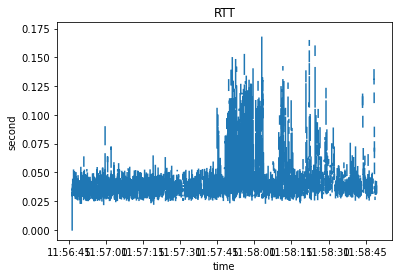

In [180]:
rtt_plot(txdf2)

294032
0.4258794128448323


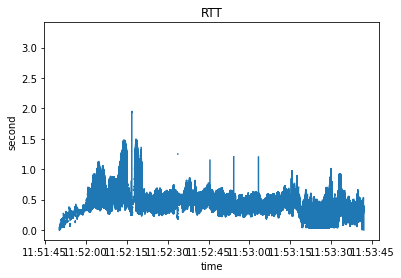

In [181]:
rtt_plot(txdf)

78290
0.03760330069537921


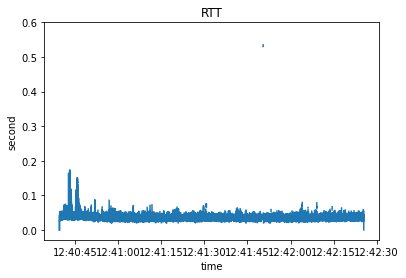

In [182]:
rtt_plot(txdf3)